# Plot matern correlation functions in lat/lon and lat (orlon)/z space

In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import cmocean
import cartopy.crs as ccrs

from corrpacmap import CorrelationPacMap
from llcmap import PacificMap

In [178]:
from matplotlib.transforms import Bbox

In [191]:
fig_dir = '../figures'
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

In [9]:
plt.style.use('./correlation.mplstyle')

In [27]:
ds = xr.open_zarr('/scratch2/tsmith/generic-matern-covariance/sampling/llc90/zstores/matern-pacmap/equator.20dx.01xi/')
ds2 = xr.open_zarr('/scratch2/tsmith/generic-matern-covariance/sampling/llc90/zstores/matern-pacmap/coast.20dx.01xi/')
for key in ds2.data_vars:
    ds[key] = ds2[key]
ds = ds.squeeze()

In [68]:
cc = CorrelationPacMap(log10tol=-15, n_range=20, persist=False, drop_coords=False)
cds = cc.open_dataset()
ds["normalization"] = cds["smooth3Dnorm001"].load()

In [28]:
ds.load();

### The map

In [29]:
mapper = PacificMap(ds)

In [92]:
cmap1 = plt.get_cmap("Greens", 10)
cmap2 = cmap1.copy()
cmap2.set_bad([.8]*3)
cmap3 = plt.get_cmap("Purples_r", 10)
cmap4 = cmap3.copy()
cmap4.set_bad([.8]*3)

/scratch2/tsmith/miniconda3/envs/phd/lib/python3.9/site-packages/matplotlib/colors.py:621: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


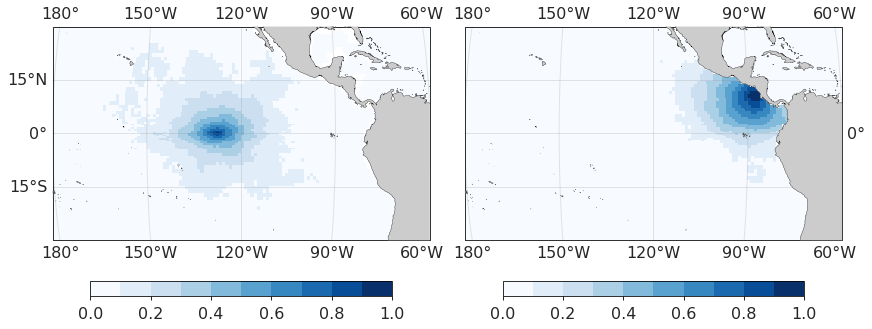

In [31]:
fig, axs = plt.subplots(1,2, figsize=(12, 6), constrained_layout=True,
                        subplot_kw={"projection":ccrs.Robinson(central_longitude=-120)})

for fld, k, ax in zip(["corr_equator", "corr_coast"],
                      [25, 0],
                      axs):
    mapper(ds[fld].sel(k=k),
           vmin=0,
           vmax=1,
           cmap=cmap,
           ax=ax)
    #ax.set_extent([-180, -60, -30, 30], ccrs.PlateCarree())

In [195]:
projection = ccrs.Robinson(central_longitude=-120)
mkw = {'vmin':0, 'vmax':1, 'cmap':cmap1, 'show_cbar': False}
nkw = {'cmap':cmap3, 'show_cbar': False}
pkw = {'vmin':0, 'vmax':1, 'cmap':cmap2}
xrange = [-180, -60]

/tmp/ipykernel_75784/2792532378.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set(xlim=xrange,
/scratch2/tsmith/miniconda3/envs/phd/lib/python3.9/site-packages/matplotlib/colors.py:621: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


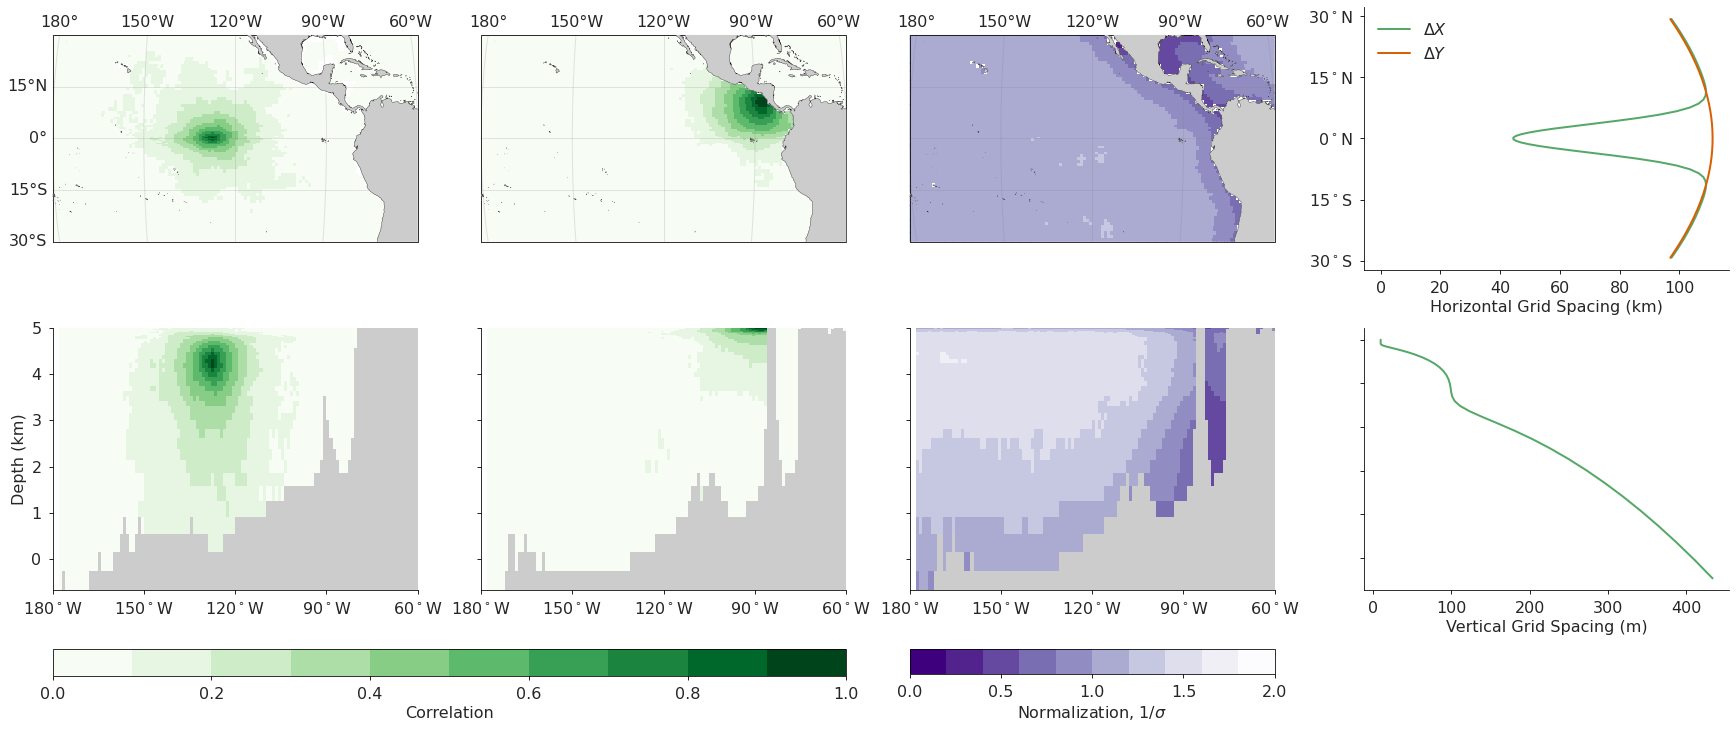

In [197]:
fig = plt.figure(figsize=(24, 10), constrained_layout=True)

axstop = []
axsbot = []

for i, (fld, k, iy) in enumerate(zip(["corr_equator", "corr_coast"],
                                     [25, 0],
                                     [165, 180])):
                                   
    # Lat / Lon
    ax0 = fig.add_subplot(2, 4, i+1, projection=projection)
    mapper(ds[fld].sel(k=k), ax=ax0, **mkw)
    mapheight = get_ax_height(ax0)
    axstop.append(ax0)
    
    # Z / Lon
    ax1 = fig.add_subplot(2, 4, i+5)
    
    xds = ds.sel(ix=slice(40,None))
    pcorr = ax1.pcolormesh(xds.XC.sel(iy=iy), -xds.Z,
                      xds[fld].where(xds.maskC).sel(iy=iy),
                      **pkw)
    ax1.invert_yaxis()
    ifc = ax1.get_subplotspec().is_first_col()
    ylabel = 'Depth (km)' if ifc else ''
    yticklabels = np.arange(5,-1, -1) if ifc else []
    xticklabels = [r"%d$^\circ$W" % lon for lon in np.arange(180, 50, -30)]
    ax1.set(xlim=xrange,
           xticks=np.arange(-180,-50, 30),
           xticklabels=xticklabels,
           ylabel=ylabel,
           yticklabels=yticklabels,
          )
    axsbot.append(ax1)
    

# Normalization
ax = fig.add_subplot(2, 4, 3, projection=projection)
ax.sharey(ax0)
mapper(ds['normalization'].sel(k=0), ax=ax, vmin=0, vmax=2,**nkw)
axstop.append(ax)
    
# Lat/Lon Grid
ax = fig.add_subplot(2, 4, 4)
yc = ds.YC.sel(ix=90)
yc = yc.where((yc<=30) & (yc>=-30))
ax.plot(yc.dxF / 1000, yc, label=r"$\Delta X$")
ax.plot(yc.dyF / 1000, yc, label=r"$\Delta Y$")
ax.set(xlabel="Horizontal Grid Spacing (km)",
       yticks=np.arange(-30, 31, 15),
       yticklabels=[r"%d$^\circ$S" % y for y in [30, 15]]+\
                   [r"%d$^\circ$N" % y for y in [0, 15, 30]])
ax.legend()
#bb = ax.get_position()
#bb0= ax0.get_position()
#newbb = Bbox([[bb.xmin, bb0.ymin], [bb.xmax, bb0.ymax]])
#ax.set_position(newbb)
axg=ax

# Normalization
ax = fig.add_subplot(2,4,7)
pnorm = ax.pcolormesh(xds.XC.sel(iy=iy), -xds.Z,
                  xds['normalization'].where(xds.maskC).sel(iy=180),
                  cmap=cmap4,
                     vmin=0, 
                     vmax=2)
ax.invert_yaxis()
ax.set(xlim=xrange,
       xticks=np.arange(-180,-50, 30),
       xticklabels=xticklabels,
       ylabel='',
       yticklabels=[])
axsbot.append(ax)

# Z grid
ax = fig.add_subplot(2,4,8)
ax.plot(ds.drF, -ds.Z, label=r"$\Delta Z")
ax.invert_yaxis()
ax.set(xlabel="Vertical Grid Spacing (m)",
       ylabel="",
       yticklabels=[])

fig.colorbar(pcorr,
             ax=axsbot[:2],
             orientation='horizontal',
             aspect=30,
             label='Correlation')

fig.colorbar(pnorm,
             ax=axsbot[-1],
             orientation='horizontal',
             aspect=15,
             label=r'Normalization, $1/\sigma$')
fig.savefig(f"{fig_dir}/huge_correlation_map.jpg", dpi=300, bbox_inches='tight')

In [185]:
bb0

Bbox([[0.3271739130434783, 0.5938751289440787], [0.4956521739130435, 0.8229430528741031]])

In [186]:
bb

Bbox([[0.7315217391304348, 0.5368181818181819], [0.9000000000000001, 0.88]])

In [187]:
newbb

Bbox([[0.7315217391304348, 0.5938751289440787], [0.9000000000000001, 0.8229430528741031]])

In [166]:
ax0.get_position()

Bbox([[0.2759782143373843, 0.6741344300684275], [0.4872898582175925, 0.9614398623304247]])

In [169]:
bb = ax0.get_position()

In [171]:
bb.ymin

0.6741344300684275

In [173]:
bb.y1

0.9614398623304247

In [ ]:
plt.Bb

In [167]:
axg.get_position()

Bbox([[0.7869521061197918, 0.6397412923988525], [0.99826375, 0.9958329999999999]])

In [168]:
ax.get_position()

Bbox([[0.7869521061197918, 0.20281625146437196], [0.99826375, 0.5589079590655192]])